## Sequence Models  - Recurrent Neural Network

1. Data Preprocessing
2. Test train split, encoding and visualization
3. Basic RNN - testing inference
4. Evaluation and training the model
5. LSTM
6. GRU
7. Exercises

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string, random, time, math

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from IPython.display import clear_output, Image
from google.colab import files
from tqdm import tqdm_notebook

In [2]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## 1. Dataset

Task - Given the name we have to identify the language (classifcation task)

The name is string here and we need to read each character in sequence and built a model based on it 


1. Converting the given data in the form of list to dataframe
2. Encoding the names and labels to tensors


In [4]:
languages = []
data = []

X = []
Y = []

file_path = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/names&languages.txt'
with open(file_path,'r') as file:
  for line in file:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    Y.append(lang)
    data.append((name,lang))
    
n_languages = len(languages)
n_languages


18

In [5]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [6]:
ascii_letters = string.ascii_letters+".,;"
print(len(ascii_letters))

def encode_name(name):
  one_hot_encoded = torch.zeros(size=(len(name),1,len(ascii_letters)))
  
  for pos,letter in enumerate(name):
    index = ascii_letters.find(letter)
    one_hot_encoded[pos][0][index] = 1
    
  return one_hot_encoded

def encode_language(language):
  return torch.tensor([languages.index(language)])

55


In [7]:
# convert the list to dataframes

data = pd.DataFrame({'name':X, 'language':Y})
data.head()

,name,language
0,Abreu,Portuguese
1,Albuquerque,Portuguese
2,Almeida,Portuguese
3,Alves,Portuguese
4,Araujo,Portuguese


In [8]:
# encoding the names and language
data['encoded_name'] = [encode_name(name) for name in data['name'].values]
data['encoded_lang'] = [encode_language(lang) for lang in data['language'].values]
data.head()

,name,language,encoded_name,encoded_lang
0,Abreu,Portuguese,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",[tensor(0)]
1,Albuquerque,Portuguese,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",[tensor(0)]
2,Almeida,Portuguese,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",[tensor(0)]
3,Alves,Portuguese,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",[tensor(0)]
4,Araujo,Portuguese,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(...",[tensor(0)]


In [9]:
print(data['encoded_name'][0].size(), '&',data['encoded_lang'][0].size())

torch.Size([5, 1, 55]) & torch.Size([1])


## 2. Visualizing the data

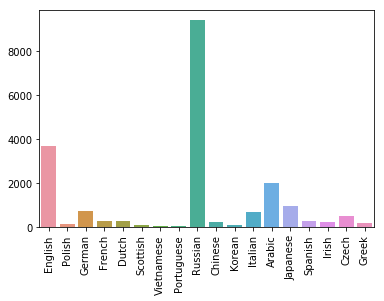

In [10]:
# random sampling
value_counts = data['language'].value_counts(sort=False)
sns.barplot(value_counts.index, value_counts.values)
plt.xticks(rotation=90)
plt.show()

Observation
1. Since the dataset is skewed,  the accuracy shouldn't be checked for overall triainset but it should be evaluated on basis per class accuracy

## 3. Train Test Split

In [11]:
X = data.iloc[:,0:data.shape[1]-1].values
Y = data.loc[:,'encoded_lang'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify=Y, test_size=0.2, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(16040, 3) (4010, 3) (16040,) (4010,)


## 4. Data Loader

In [12]:
def dataloader(X,Y,nper_class=1):
  dataframe = pd.DataFrame(np.hstack((X,Y.reshape(-1,1))),columns=data.columns)
  batch_data = []
  for lang,df in dataframe.groupby('language'):
    indices = np.random.choice(range(len(df)),nper_class)
    batch_data.append(df.iloc[indices,:])
  return pd.concat(batch_data)

df = dataloader(X_train,Y_train,nper_class=12)
df['language'].value_counts()

Irish         12
Portuguese    12
Vietnamese    12
Italian       12
Japanese      12
Polish        12
English       12
Chinese       12
Czech         12
Russian       12
German        12
Greek         12
Scottish      12
Spanish       12
Arabic        12
Korean        12
French        12
Dutch         12
Name: language, dtype: int64

## 5. Model

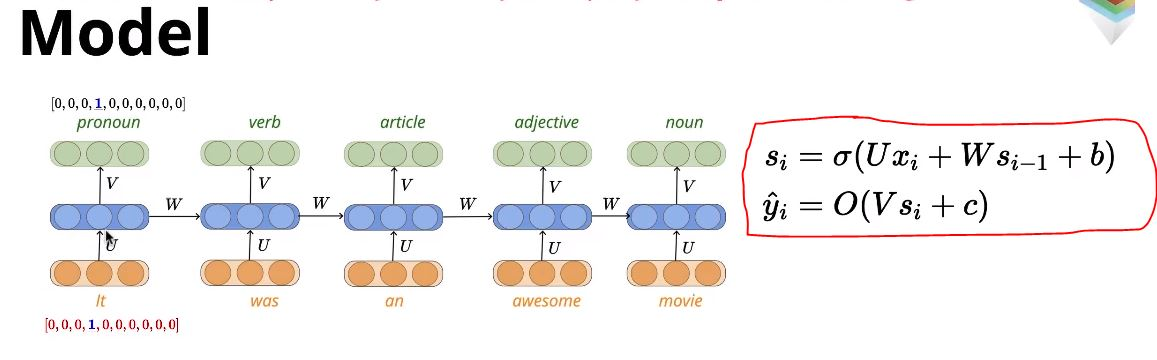

In [13]:
image_file = r'/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/13. Sequence models- RNN/Basic_RNN_model.JPG'
Image(image_file)

Note: Here the hidden size is to be given by the **user**

In [0]:
class RNN_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_net, self).__init__()
    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)
    
    
  def forward(self, input_, hidden):
    combined  = torch.cat((input_,hidden),1) # concatenating the input and the previous hidden layer
    hidden = self.i2h(combined)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output, hidden
  
  
  
  # for the initial input (letter) we dont have the hidden layer ouputs of the previous layer
  # hence this function will be used to initiate the hidden layer for the first input
  def init_hidden(self):
    return torch.zeros(1,self.hidden_size).to(device)

- Since we are using the logarithm on softmax, we will get numbers in [-inf, 0], since log(0)=-inf and log(1)=0.
- We can get the probabilities back by using **torch.exp(output)**.

In [0]:
n_hidden = 128
n_letters = len(ascii_letters)
net = RNN_net(n_letters, n_hidden, len(languages)).to(device)

In [16]:
# inference of the model

def infer_model(net,name):
  net.eval()
  hidden = net.init_hidden()
  encoded = encode_name(name).to(device)
  for i in range(encoded.size()[0]):
    output,hidden = net(encoded[i],hidden)
    
  return output

infer_model(net,'John')

tensor([[-2.7855, -2.9206, -2.8202, -2.8102, -2.8530, -2.8860, -2.9293, -2.9627,
         -2.9030, -2.9682, -2.8248, -2.9559, -2.9861, -2.8697, -2.9429, -2.8734,
         -2.8540, -2.9114]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

In [17]:
encode_name('john').size()

torch.Size([4, 1, 55])

## 6. Evaluation of the model

In [18]:
def evaluation(X,Y, net, nper_class=1, k=1):
  k = 1
  correct = 0
  net.eval()
  batch_data = dataloader(X,Y,nper_class=nper_class)
  
  for i in range(batch_data.shape[0]):
    row = batch_data.iloc[i,:]
    name = row['name']
    encoded_lang = row['encoded_lang'].to(device)
    output = infer_model(net,name)

    val,indices = output.topk(k)
    if encoded_lang in indices:
      correct +=1


  return correct/len(batch_data)
  
  
evaluation(X_test,Y_test,net,nper_class=12)

0.05555555555555555

## 7. Training the model


1. This is a sequence learning problem where we have to learn the sequence of letters in a given name and classify the name into language
2. while training the model we have to iterate over the one-hot encoded letters and compute the loss
3. then backpropagate the loss compute the gradient
4. Once the backpropagation is done for every letter in the sequence of a name then we update the weights  

### 7.1 Basic setup

In [0]:
def train_model(net, opt, criterion, nper_class=12):
  
  opt.zero_grad()
  data_ = dataloader(X,Y,nper_class=nper_class)
  total_loss = 0
  for j in range(data_.shape[0]):
    row = data_.iloc[j,:]
    
    encoded_name, encoded_lang = row['encoded_name'].to(device), row['encoded_lang'].to(device)
    hidden = net.init_hidden()
    
    for i in range(len(encoded_name)):  # iterating over the sequence of letters in a name
      
      output,hidden = net(encoded_name[i],hidden)
    
    loss = criterion(output,encoded_lang)
    loss.backward(retain_graph=True)

    total_loss += loss

  opt.step()
  
  return total_loss/len(data_)  # return the average loss

1. Retain Graph function

**RuntimeError**: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

2. Difference between cross entropy loss and Negtive log likelihood loss (NLLLoss) 
-If our model outputs the softmax of the last layer then NLLLoss should be used otherwise we should use cross entropy loss function

In [20]:
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
train_model(net, opt, criterion)

tensor(2.8943, device='cuda:0', grad_fn=<DivBackward0>)

In [21]:
## Evaluation of the model

evaluation(X_test,Y_test, net, nper_class=12, k=1)

0.14351851851851852

### 7.2 Full setup for training

In [0]:
def train_setup(net,lr=0.0005, n_batches=100, nper_class=12, momentum=0.9, display_freq = 5):

  criterion = nn.NLLLoss()
  opt = optim.Adam(net.parameters(), lr=lr)
  loss = np.zeros(n_batches+1)
  for i in tqdm_notebook(range(n_batches),unit=' Batch',total=n_batches):
    loss[i+1] = (loss[i]*i + train_model(net, opt, criterion, nper_class=nper_class))/(i + 1)
    
    if i % display_freq == 0:
      clear_output(wait=True)
      plt.figure()
      plt.plot(loss[1:i],'-*')
      plt.title('Training of Recurrent Neural Network')
      plt.xlabel('Iteration')
      plt.ylabel('Log Loss')
      plt.show() 
      
  print('Top 1 accuracy:',evaluation(X_test,Y_test, net, nper_class=2, k=1), '| Top 2 accuracy:',evaluation(X_test,Y_test, net, nper_class=2, k=2))

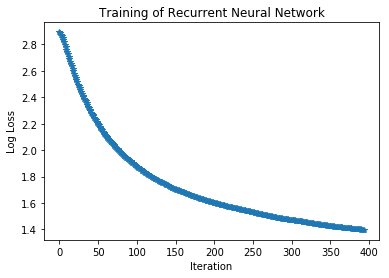


Top 1 accuracy: 0.7777777777777778 | Top 2 accuracy: 0.6944444444444444
CPU times: user 3min 18s, sys: 17.5 s, total: 3min 35s
Wall time: 3min 22s


In [23]:
%%time 
n_hidden = 128
lr = 0.005
net = RNN_net(n_letters, n_hidden, len(languages)).to(device)
train_setup(net, lr=lr,n_batches=400, nper_class=12)

## 8. LSTM models

Long short-term memory - used to overcome the vanishing and exploding of gradients in the sequence learning models. 

It uses selective read, write and forget algorithms to prevent the gradients from vanishing or exploding

In [0]:
class LSTM_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(LSTM_net, self).__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    
  def forward(self, input_, hidden):
    out, hidden = self.lstm_cell(input_.view(1,1,-1), hidden)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output.view(1,-1), hidden
  
  def init_hidden(self):
    return (torch.zeros(1,1,self.hidden_size).to(device), torch.zeros(1,1,self.hidden_size).to(device))
    # one for the hidden state and one for the usual cell state which was also present in the simple RNN model                    

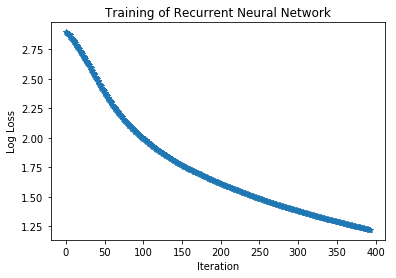


Top 1 accuracy: 0.7222222222222222 | Top 2 accuracy: 0.7777777777777778
CPU times: user 7min 16s, sys: 34.9 s, total: 7min 51s
Wall time: 7min 37s


In [25]:
%%time
hidden_size = 128
lstm_net = LSTM_net(n_letters, hidden_size, len(languages)).to(device)
lr = 0.005
train_setup(lstm_net, lr=lr,n_batches=400,  nper_class=12)

## 8. GRU - Gated Recurrent units 

Modified version of LSTM. here it doesnot have forget gate instead it has two gates input and output

In [0]:
class GRU_net(nn.Module):
  def __init__(self,input_size, hidden_size, output_size):
    super(GRU_net, self).__init__()
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=2)
    
  def forward(self, input_, hidden):
    out, hidden = self.gru_cell(input_.view(1,1,-1), hidden)
    output = self.h2o(hidden)
    output = self.softmax(output)
    return output.view(1,-1), hidden
  
  def init_hidden(self):
    return torch.zeros(1,1,self.hidden_size).to(device)
    # we have only state i.e. hidden state                

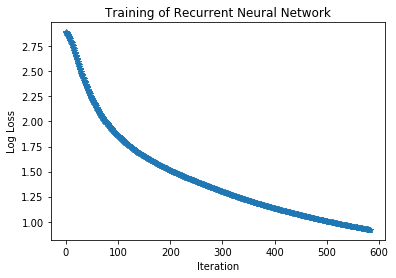

In [0]:
%%time
hidden_size = 128
gru_net = GRU_net(n_letters, hidden_size, len(languages)).to(device)
lr = 0.005
train_setup(gru_net, lr=lr,n_batches=600,  nper_class=12)

## 9. Exercises

1. what is cell state and hidden state
2. plot the language wise accuaracy -> plot the confusion matrix
3. Optimize the model by modifying the hyperparameters
4. Observe gradient explosion at higher learning rates
5.  Increasing the performence by using GPU
6. Use batching while training

In [0]:
def accuracies_per_class(X,Y,model):
  temp_data = pd.DataFrame(np.hstack((X,Y.reshape(-1,1))),columns = data.columns)
  output = {}
  for lang, df in temp_data.groupby('language'):
    names = df['name']
    index = encode_language(lang)[0]
    correct = 0
    for name in names:
      prediction = torch.argmax(infer_model(model,name)).cpu()
      if index == prediction:
        correct += 1

    output[lang] = correct/df.shape[0]

  sns.barplot(list(output.keys()),list(output.values()))
  plt.xticks(rotation=90)
  plt.xlabel('Language')
  plt.ylabel('Accuracy (%)')
  plt.show() 
  
  
accuracies_per_class(X_test, Y_test,net)  

In [0]:
%%time
accuracies_per_class(X_test, Y_test,lstm_net)

In [0]:
%%time
accuracies_per_class(X_test, Y_test,gru_net)

In [0]:
languages[torch.argmax(infer_model(gru_net,'Ronaldo'),dim=1).cpu().numpy()[0]]